# E-commerce — Выявление профилей потребления

 ### Описание проекта 

Интернет-магазин товаров для дома «Пока все ещё тут» стремясь сделать покупки максимально удобными для каждого клиент хочет лучше понять их и создать рекламу, которая будет им действительно интересна. Для этого нам необходимо провести исследование предоставленных данных с целью сегментирования клиентской базы и выявления ключевых характеристик каждой группы покупателей.  Это позволит интернет-магазину разработать таргетированные рекламные кампании, которые будут отвечать специфическим потребностям, и интересам каждого сегмента.

**Цель:**

Сегментировать покупателей по профилю потребления для осуществления рекламных рассылок.

**Задача:**

- Очистка и обработка данных.
- Анализ покупательских привычек, выявление закономерностей.
- Создание профилей покупателей с учетом их потребностей.
- Проверка гипотез.
- Написание вывода и рекомендации.

 ### План работы

**[1. Общий анализ данных](#section_id1):**
* Загрузка данных       
* Предварительный анализ данных
* Предобработка данных
* [Вывод](#section_id2)
  
**[2. Исследовательский анализ даных](#section_id3):**
* Описательная статистика  
* Средняя стоимость товара    
* Средняя частота покупок      
* Среднее количество товара в заказе
* Популярные товары
* Анализ сезонности   
* Кластеризация 
* Визуализация сегментов
* [Вывод](#section_id4)
  
**[3. Проверка гипотез](#section_id5):**
* Проверим нулевую и альтернативную гипотезу      
* [Вывод](#section_id6)
  
**[4. Создание профилей покупателей](#section_id7):**
* Опишем  каждый  сегмент  с  учетом  их  потребностей  и  характеристик, а также дадим рекомендации.
  
**[5. Общий вывод](#section_id8)**

 ### Описание данных   

Файл ecom_dataset_upd.csv

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

<a id='section_id1'></a>

## Изучение данных

#### Импортируем необходимые библиотеки и загрузим данные из файла ecom_dataset_upd.csv.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
from sklearn.metrics import silhouette_score
import nltk
import pymorphy2
import re
from sklearn.preprocessing import MinMaxScaler

In [21]:
try:
    df = pd.read_csv('../datasets/com_dataset_upd.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net///datasets/ecom_dataset_upd.csv')

In [22]:
#проверим загрузку данных
df.sample(5)

,date,customer_id,order_id,product,quantity,price
6212,2019082812,49f2b06a-67a6-4b8d-aa4c-f91a2b0ba09b,72437,Полки QWERTY Торонто белый 40х10 см 35х10 см 3...,1,3524.0
1144,2018120922,0e26f0b8-0801-4578-8337-40f12a764255,69267,Коврик Sochi 50х80 см коричневый 5801,1,239.0
5002,2019061009,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Патиссона сорт Диск, кассета по 6шт",1,120.0
1724,2019020619,3bff3367-00fe-4cc1-a058-d5d61aecff6a,70132,Тележка багажная DELTA ТБР-20 синий грузоподъе...,1,727.0
5263,2019061322,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Огурца сорт Каролина кассета 6 шт E6,1,120.0


#### Изучим общую информацию о датасете.

In [24]:
def infoOut(data, details=False, missing_values=False):
    #  Создаем пустой DataFrame для хранения информации о столбцах
    dfInfo = data.columns.to_frame(name='Column')
    #  Добавляем столбец с количеством непустых значений
    dfInfo['Non-Null Count'] = data.notna().sum()
    #  Добавляем столбец с количеством пропущенных значений
    dfInfo['Missing Values'] = data.isnull().sum()    
    #  Добавляем столбец с типом данных столбца
    dfInfo['Dtype'] = data.dtypes    
    #  Добавляем столбец с количеством дубликатов
    dfInfo['Duplicates'] = data.duplicated().sum()    
    #  Сбрасываем индексы
    dfInfo.reset_index(drop=True, inplace=True)    
    #  Проверяем, нужно ли добавлять подробную информацию
    if details:
        #  Рассчитываем диапазон значений в столбце 'Non-Null Count'
        rangeIndex = (dfInfo['Non-Null Count'].min(), dfInfo['Non-Null Count'].max())        
        #  Подсчитываем общее количество столбцов
        totalColumns = dfInfo['Column'].count()        
        #  Подсчитываем количество значений каждого типа данных
        dtypesCount = dfInfo['Dtype'].value_counts()        
        #  Рассчитываем общий размер памяти, занимаемый датафреймом
        totalMemory = data.memory_usage().sum()       
        #  Рассчитываем процент дубликатов
        duplicate_percentage = (dfInfo['Duplicates'] / len(data)) * 100        
        #  Проверяем, нужно ли добавлять информацию о пропущенных значениях
        if missing_values:
            #  Рассчитываем процент пропущенных значений
            missing_percentage = (dfInfo['Missing Values'] / len(data)) * 100            
            #  Возвращаем все рассчитанные значения
            return dfInfo, rangeIndex, totalColumns, dtypesCount, totalMemory, data.isnull().sum(), dfInfo['Duplicates'], duplicate_percentage, missing_percentage
        else:
            #  Возвращаем все рассчитанные значения, кроме информации о пропущенных значениях
            return dfInfo, rangeIndex, totalColumns, dtypesCount, totalMemory, duplicate_percentage
    else:
        #  Возвращаем только информацию о столбцах
        return dfInfo
#  Выводим заголовок
print("----- DataFrame Info -----")
#  Вызываем функцию infoOut с параметрами details=True и missing_values=True
df_info = infoOut(df, details=True, missing_values=True)
#  Распаковываем значения из df_info
dfInfo = df_info[0]
rangeIndex = df_info[1]
totalColumns = df_info[2]
dtypesCount = df_info[3]
totalMemory = df_info[4]
missingValues = df_info[5]
duplicates = df_info[6]
duplicate_percentage = df_info[7]
missing_percentage = df_info[8]
#  Добавляем столбец с индикатором дубликатов строк
dfInfo['Duplicate Rows'] = df.duplicated()
#  Добавляем столбец с процентом пропущенных значений
dfInfo['Missing Value Percentage'] = round(missing_percentage)
#  Выводим DataFrame с информацией
display(dfInfo)
#  Выводим общее количество столбцов
display(f"Total Columns: {totalColumns}")
#  Выводим размер памяти, занимаемый датафреймом
print(f"Memory Usage: {totalMemory} bytes")
#  Выводим заголовок
print("\n----- DataFrame Describe -----")
#  Выводим описательную статистику датафрейма
display(df.describe(include='all'))

----- DataFrame Info -----


,Column,Non-Null Count,Missing Values,Dtype,Duplicates,Duplicate Rows,Missing Value Percentage
0,date,7474,0,int64,0,False,0.0
1,customer_id,7474,0,object,0,False,0.0
2,order_id,7474,0,int64,0,False,0.0
3,product,7474,0,object,0,False,0.0
4,quantity,7474,0,int64,0,False,0.0
5,price,7474,0,float64,0,False,0.0


'Total Columns: 6'

Memory Usage: 358884 bytes

----- DataFrame Describe -----


,date,customer_id,order_id,product,quantity,price
count,7.474000e+03,7474,7474.000000,7474,7474.000000,7474.000000
unique,NaN,2451,NaN,2343,NaN,NaN
top,NaN,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,NaN,Рассада Кабачка сорт Зебра кассета 6 шт E6,NaN,NaN
freq,NaN,888,NaN,79,NaN,NaN
mean,2.018913e+09,NaN,49449.884265,NaN,2.362858,478.737501
std,4.278878e+05,NaN,32679.642404,NaN,14.500497,901.615895
min,2.018100e+09,NaN,12624.000000,NaN,1.000000,9.000000
25%,2.019022e+09,NaN,14833.000000,NaN,1.000000,97.000000
50%,2.019051e+09,NaN,68768.000000,NaN,1.000000,135.000000
75%,2.019063e+09,NaN,71257.750000,NaN,1.000000,439.000000


<u>Количество записей: 7474 записей. Это значит, что у нас есть данные о 7474 покупках.

<u>***date:*** Данные охватывают период с 2018 по 2020 год. В данных нет пропущенных значений в поле "дата". Тип данных -  целое число (integer). Необходимо преобразовать в дату (datetime), чтобы было удобнее работать с временными рядами.

<u>***customer_id:*** В датасете 2451 уникальный клиент, некоторые из которых совершали покупки несколько раз. Tип данных - текст (object).

<u>***order_id:*** Каждая строка в датасете - это отдельный заказ, всего 7474 заказа. Тип данных -  целое число (integer).

<u>***product:*** 2343 уникальных товаров. Тип данных - текст (object).

<u>***quantity:*** В среднем покупатели заказывают 2.36 товара за раз. Тип данных -  целое число (integer).

<u>***price:*** Средняя cумма покупки - 478 рублей. Самый дорогой товар стоит 14917 рублей, а самый дешевый - 9 рублей. Тип данных -  число с плавающей точкой (float).</u> 

#### Проведем проверку на выявление неявных дубликатов.

Напишем функцию сравнения названий

In [28]:
def find_similar_names(df):
    unique_names = set(df['product'].unique()) 
    count = 0  # Добавляем счетчик для найденных пар имен
    

    for i, name1 in enumerate(unique_names):
        for j, name2 in enumerate(unique_names):
            if i == j:  # Проверка, что это не одно и то же имя
                continue
            
            # Проверяем разницу в длине имен
            if len(name1) - len(name2) <= 2 and len(name1) - len(name2) >= -2: 
                # Проверяем, совпадают ли первые или последние буквы
                if name1[0] == name2[0] or (name1[0] != name2[0] and name1[-1] == name2[-1]):
                    # Рассчитываем расстояние Левенштейна
                    distance = nltk.distance.edit_distance(name1, name2, substitution_cost=1, transpositions=False)
                    # Проверяем, близки ли имена
                    if 0 < distance < 2:
                        print(f'Имя "{name1}" —  Имя "{name2}"')
                        count += 1  # Увеличиваем счетчик
    
    print(f'\n\nНайдено из {len(unique_names)} уникальных значений {count} пар похожих.')

Проверим на схожесть названия в столбце product

In [30]:
# Вызываем функцию
find_similar_names(df) 

Имя "Сушилка для белья потолочно-настенная Gimi Lift 240 5031" —  Имя "Сушилка для белья потолочно-настенная Gimi Lift 240, 5031"
Имя "Сушилка для белья на батарею, СБ5-65, НИКА" —  Имя "Сушилка для белья на батарею, СБ5-45, НИКА"
Имя "Лестница-стремянка Dogrular Ufuk оцинкованная 7-ми ступенчатая" —  Имя "Лестница-стремянка Dogrular Ufuk оцинкованная 8-ми ступенчатая"
Имя "Сушилка для белья потолочно-настенная Gimi Lift 120" —  Имя "Сушилка для белья потолочно-настенная Gimi Lift 100"
Имя "Сушилка для белья потолочно-настенная Gimi Lift 120" —  Имя "Сушилка для белья потолочно-настенная Gimi Lift 140"
Имя "Сушилка для белья потолочно-настенная Gimi Lift 120" —  Имя "Сушилка для белья потолочно-настенная Gimi Lift 160"
Имя "Сушилка для белья потолочно-настенная Gimi Lift 120" —  Имя "Сушилка для белья потолочно-настенная Gimi Lift 180"
Имя "Лестница-стремянка Dogrular Ufuk оцинкованная 4-х ступенчатая" —  Имя "Лестница-стремянка Dogrular Ufuk оцинкованная 3-х ступенчатая"
Имя "Муляж Зе

<u>Найдено 82 пары с похожими именами из 2343 уникальных значений, что составляет всего 3,5 %. Это означает что большинство имен в данных уникальны и среди найденых пар отличие в основном в номере моделе что говорит в большенстве случаев об их уникальности.</u> 

Обработаем дубликаты

In [33]:
def check_duplicates(df, columns):
  """
  Проверяет дубликаты строк по заданным столбцам.

  Args:
    df: DataFrame для проверки.
    columns: Список столбцов для сравнения.

  Returns:
    DataFrame с дубликатами строк.
  """
  duplicates = df.duplicated(subset=columns, keep=False)
  duplicate_rows = df[duplicates]
  return duplicate_rows

# Проверка дубликатов
duplicate_row = check_duplicates(df, ['product', 'order_id', 'quantity'])

# Вывод результата
print(f'Дубликаты найдены в {len(duplicate_row)} строках:')


Дубликаты найдены в 2426 строках:


<u>Анализ данных выявил дубликаты в 2426 строках, различающихся только датой, среди 7474 строк. Дубликаты идентифицированы на основе совпадения по столбцам `product`, `order_id` и `quantity`. Это свидетельствует о наличии ошибок в датах, что может быть связано с ошибками или системными сбоями.</u>

#### Выполним предобработку данных

Удалим дубликаты

In [37]:
# Удаление дубликатов
df.drop_duplicates(subset=['order_id', 'product', 'quantity'], keep='first', inplace=True)

Проверим результат удаление дубликатов

In [39]:
# Проверка дубликатов
duplicate_row = check_duplicates(df, ['order_id', 'product', 'quantity'])
# Вывод результата
print(f'Дубликаты найдены в {len(duplicate_row)} строках:')

Дубликаты найдены в 0 строках:


Обработаем выбросы

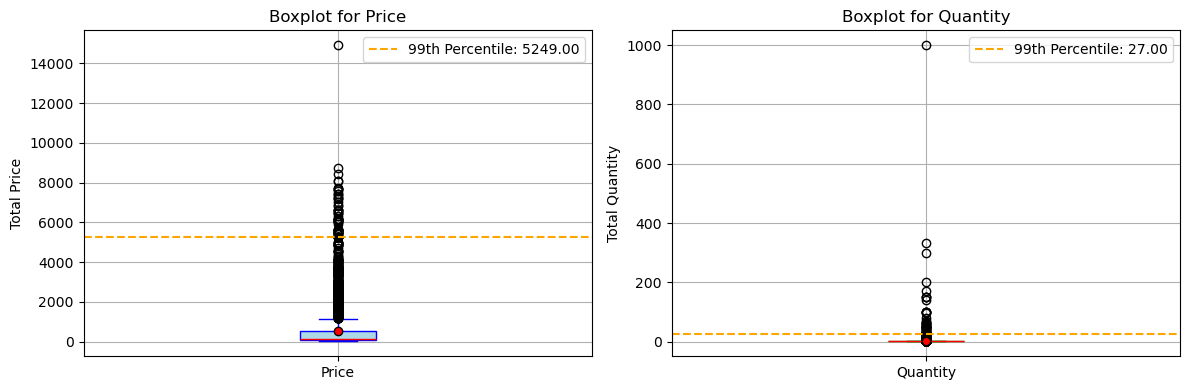

In [41]:
plt.figure(figsize=(12, 4))  # Устанавливаем размер графика

# Вычисляем 99-percentile
price_99 = np.percentile(df['price'], 99)
quantity_99 = np.percentile(df['quantity'], 99)

# Boxplot для 'price'
plt.subplot(1, 2, 1)  # Создаем подграфик (1 строка, 2 колонки, 1-й подграфик)
box_price = plt.boxplot(df['price'], vert=True, patch_artist=True, showmeans=True,
                        boxprops=dict(facecolor='lightblue', color='blue'), 
                        whiskerprops=dict(color='blue'), 
                        capprops=dict(color='blue'), 
                        medianprops=dict(color='red'),
                        meanprops=dict(marker='o', markeredgecolor='black', markerfacecolor='red'))  # Обозначение среднего

# Добавляем 99-й процентиль
plt.axhline(y=price_99, color='orange', linestyle='--', label=f'99th Percentile: {price_99:.2f}')
plt.title('Boxplot for Price')
plt.ylabel('Total Price')
plt.grid()
plt.xticks([1], ['Price'])
plt.legend()  # Добавляем легенду
plt.tight_layout()  # Автоматически подстраиваем параметры подграфиков

# Boxplot для 'quantity'
plt.subplot(1, 2, 2)  # Создаем подграфик (1 строка, 2 колонки, 2-й подграфик)
box_quantity = plt.boxplot(df['quantity'], vert=True, patch_artist=True, showmeans=True, 
                           boxprops=dict(facecolor='lightgreen', color='green'), 
                           whiskerprops=dict(color='green'), 
                           capprops=dict(color='green'),medianprops=dict(color='red'),
                           meanprops=dict(marker='o', markeredgecolor='black', markerfacecolor='red'))  # Обозначение среднего

# Добавляем 99-й процентиль
plt.axhline(y=quantity_99, color='orange', linestyle='--', label=f'99th Percentile: {quantity_99:.2f}')
plt.title('Boxplot for Quantity')
plt.ylabel('Total Quantity')
plt.grid()
plt.xticks([1], ['Quantity'])
plt.legend()  # Добавляем легенду
plt.tight_layout()  # Автоматически подстраиваем параметры подграфиков

plt.show()

In [42]:
# Функция для определения выбросов по методу IQR и подсчета процента выбросов
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers, outliers.mean() * 100

# Проверяем выбросы для каждого столбца и выводим процент выбросов
outliers_price, percent_outliers_price = detect_outliers_iqr(df['price'])
outliers_quantity, percent_outliers_quantity = detect_outliers_iqr(df['quantity'])


print("Выбросы в столбце 'price' (процент выбросов: {:.2f}%)".format(percent_outliers_price))
print("Выбросы в столбце 'quantity' (процент выбросов: {:.2f}%)".format(percent_outliers_quantity))

Выбросы в столбце 'price' (процент выбросов: 11.61%)
Выбросы в столбце 'quantity' (процент выбросов: 20.11%)


In [43]:
# Заменяем выбросы в столбцах 'price' и 'quantity'
for column in ['price', 'quantity']:
    upper_threshold = df[column].quantile(0.99)
    lower_threshold = df[column].quantile(0.00)
    
    # Удаляем выбросы
    df = df[(df[column] >= lower_threshold) & (df[column] <= upper_threshold)]

    # Определяем процент отфильтрованных выбросов         
    total_count = len(df)
    outlier_count = len(df[df[column] == lower_threshold]) + len(df[df[column] == upper_threshold])
    outlier_percentage = (outlier_count / total_count) * 100
    print(f"Процент отфильтрованных выбросов в столбце '{column}': {outlier_percentage:.2f}%")


print(f"Данные в столбцах 'price' и 'quantity' были очищены от выбросов методом удаления выбросов.")

Процент отфильтрованных выбросов в столбце 'price': 0.20%
Процент отфильтрованных выбросов в столбце 'quantity': 80.56%
Данные в столбцах 'price' и 'quantity' были очищены от выбросов методом удаления выбросов.


<a id='section_id2'></a>

### Вывод

***Проведенный анализ данных выявил 1195 (16%) дубликатов, различающихся только датой, среди 7474 строк. Удаление этих дубликатов позволило очистить данные от потенциальных ошибок ввода или системных сбоев.***

***В данных также используется нормализованный список товаров, что позволило минимизировать ошибки в написании названий. Большая часть товаров (2343 из 2343) имеет уникальные названия, а 82 пары с похожими названиями отличаются только номером модели.*** 

***Данные охватывают период с 2018 по 2020 год, что позволит провести анализ динамики продаж в течение этого периода.***

***Анализ данных также выявил выбросы в столбцах 'price' и 'quantity'. Процент удаленных выбросов в столбце 'price' составил 0.20%, а в столбце 'quantity' - 80.56%.***

***Проведенная очистка данных позволила улучшить их качество и повысить точность будущих анализов.***

<a id='section_id3'></a>

## Иследовательский анализ данных

#### Описательная статистика

Преобразует данные с датой в нужный формат и добавит необходимы столбцы для дальнейшего анализа

In [49]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df['month'] = df['date'].dt.month
# Преобразование "date" в формат даты
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
# Добавление столбца с днем
df['day'] = df['date'].dt.day
# Создаем список с названиями дней недели
days = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
# Добавление столбца с днем недели (0 - понедельник, 6 - воскресенье)
df['day_of_week'] = df['date'].dt.dayofweek
# Присваиваем название дня недели по номеру
df['day_of_week'] = df['day_of_week'].apply(lambda x: days[x])

Посчитаем среднюю стоимость товара для каждого покупателя

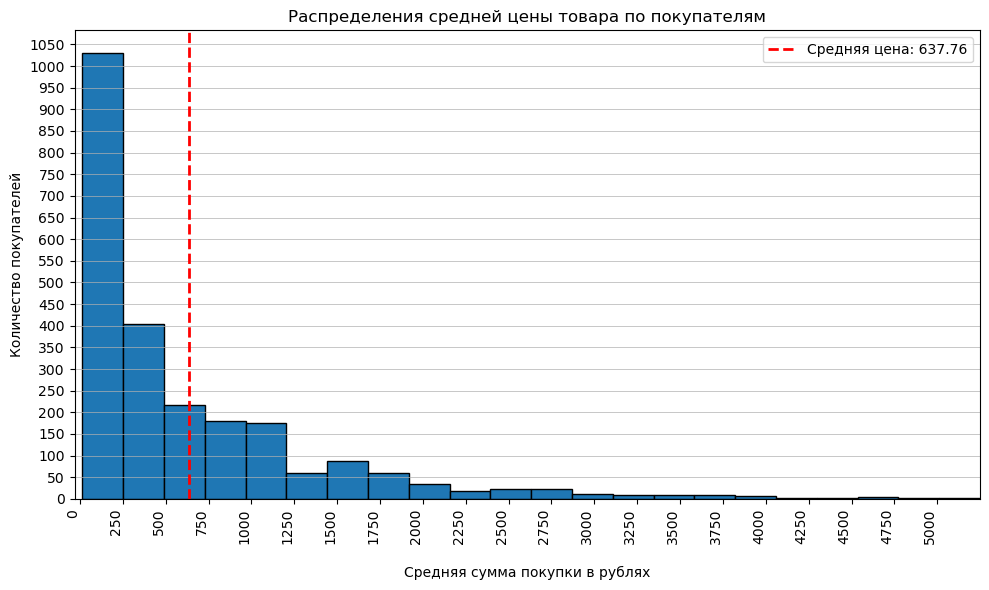

In [51]:
# Вычисляем среднюю цену для каждого покупателя
average_price_per_customer = df.groupby('customer_id')['price'].mean()

# Создаем гистограмму с увеличенным размером графика
plt.figure(figsize=(10, 6)) 
plt.hist(average_price_per_customer, bins=22, edgecolor='black') 
plt.xlabel('\nСредняя cумма покупки в рублях')
plt.ylabel('Количество покупателей')
plt.title('Распределения средней цены товара по покупателям')

# Добавляем сетку по Y
plt.grid(axis='y', linestyle='-', linewidth=0.5)

# Увеличиваем частоту надписей по оси X
plt.xticks(rotation=90, ha='right') 

# Добавляем частоту значений на оси X
plt.locator_params(axis='x', nbins=24)
plt.locator_params(axis='y', nbins=22)

# Добавляем линию средней цены
mean_price = average_price_per_customer.mean()
plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Средняя цена: {mean_price:.2f}') 

# Добавляем легенду
plt.legend()

# Убираем пустые отступы, устанавливая границы оси X
plt.xlim(-30, 5249) 

plt.tight_layout()
plt.show()

<u>Гистограмма показывает, как распределена средняя стоимость покупок среди покупателя. 
Средняя стоимость покупок у покупателя составляет 638 рублей.
Диапазон цен достаточно широкий: от минимальной стоимости 14 рублей до максимальной в 5 249 рублей.
График имеет левое смещение, то есть,  большинство покупателей тратят меньше средней стоимости, а небольшое количество покупателей делают покупки на значительно большие суммы.
Большинство покупателей (75%) тратят не более 889 рублей.<u> 

<u>В гистограмме заметны некоторые группировки (пики)  - это может быть связано с особенностями цен на товары или с группированием клиентов по определенным характеристикам.<u> 

<u>Распределение средней стоимости покупок по покупателям неравномерное. Большинство покупателей тратят сравнительно небольшие суммы, но есть группа покупателей с очень высокими средними чеками.<u> 

Посчитаем среднюю частоту покупок.

In [54]:
orders_per_customer_df = (
    df.groupby('customer_id')
    .size()
    .reset_index(name='Количество заказов')
    .groupby('Количество заказов')
    .size()
    .reset_index(name='Количество покупателей')
)
orders_per_customer_df.sort_values(by='Количество заказов')
orders_per_customer_df.index += 1  # Добавляем нумерацию с 1
#  Создаем стиль для таблицы
style = orders_per_customer_df.style.set_properties(**{
    'text-align': 'right',
    'border': '1px solid black',
    'padding': '5px'
})
#  Добавляем регулировку расстояния между строками
style.set_table_styles([
    {'selector': 'tr', 'props': [('padding', '5px'), ('border', '1px solid black')]}
])
# Добавляем заголовок с жирным шрифтом и отступом
style.set_table_styles([
    {'selector': 'caption', 'props': [('font-weight', 'bold'), ('padding-left', '20px'), ('font-size', '16px')]}
])
# Добавляем заголовок
style.set_caption('Частота покупок')
# Добавляем заголовок
style.set_caption('Частота покупок')
#  Отображаем таблицу
style

,Количество заказов,Количество покупателей
1,1,1195
2,2,887
3,3,72
4,4,31
5,5,31
6,6,25
7,7,19
8,8,15
9,9,17
10,10,16


<u>Из представленных данных видно, что большинство покупателей совершают от 1 до 3 заказов. Количество покупателей, совершающих более 10 заказов, резко снижается.  Это говорит о том, что у вас есть большая группа покупателей, совершающих небольшие покупки, и небольшая группа покупателей, совершающих крупные покупки.<u>

<u>Примечательно, что один покупатель совершил аж 143 заказа! Это может указывать на наличие постоянных клиентов, делающих регулярные покупки, или же на то, что этот покупатель был каким-то образом вовлечен в оптовую закупку.<u>  

В целом, данные указывают на неоднородность вашей клиентской базы, что может быть полезно для оптимизации маркетинговых стратегий и предложений. 

Посчитаем количество товара в заказе.

In [57]:
# Группируем по номеру заказа и считаем количество товаров в каждом заказе
items_per_order_df = (
    df.groupby('order_id')
    .size()
    .reset_index(name='Количество товаров')
    .groupby('Количество товаров')
    .size()
    .reset_index(name='Количество заказов')
)

#  Сортируем по количеству товаров
items_per_order_df.sort_values(by='Количество товаров')

# Добавляем нумерацию с 1
items_per_order_df.index += 1  

#  Создаем стиль для таблицы
style = items_per_order_df.style.set_properties(**{
    'text-align': 'right',
    'border': '1px solid black',
    'padding': '5px'
})

#  Добавляем регулировку расстояния между строками
style.set_table_styles([
    {'selector': 'tr', 'props': [('padding', '5px'), ('border', '1px solid black')]}
])

# Добавляем заголовок с жирным шрифтом и отступом
style.set_table_styles([
    {'selector': 'caption', 'props': [('font-weight', 'bold'), ('padding-left', '20px'), ('font-size', '14px')]}
])

# Добавляем заголовок
style.set_caption('Среднее количество товаров в заказе')

#  Отображаем таблицу
style

,Количество товаров,Количество заказов
1,1,3009
2,2,104
3,3,70
4,4,44
5,5,35
6,6,36
7,7,20
8,8,16
9,9,17
10,10,17


<u>Большинство заказов содержат 1 товар. Это видно по тому, что количество заказов с 1 товаром значительно больше, чем с любым другим количеством.
Количество заказов с большим количеством товаров резко снижается. С увеличением количества товаров в заказе количество заказов с этим количеством товаров быстро падает.<u> 
<u>Есть несколько "выбросов" с большим количеством товаров. Например, заказы с 51 товаром или 36 товарами. Это может быть связано с оптовыми покупками или особыми заказами.<u>

<u>В целом, данные говорят о том, что большинство покупателей делают небольшие заказы, и заказы с большим количеством товаров встречаются редко.<u>  

Создадим рейтинг самых популярных товаров

In [60]:
# Популярные товары
top_products = df['product'].value_counts().nlargest(5).reset_index()
top_products.columns = ['Товар', 'Количество заказов']
top_products.index += 1  # Добавляем нумерацию с 1

style = top_products.style.set_properties(**{
    'text-align': 'right',
    'border': '1px solid black',
    'padding': '10px'
})

#  Добавляем регулировку расстояния между строками
style.set_table_styles([
    {'selector': 'tr', 'props': [('padding', '10px'), ('border', '1px solid black')]}
])

# Добавляем заголовок с жирным шрифтом и отступом
style.set_table_styles([
    {'selector': 'caption', 'props': [('font-weight', 'bold'), ('padding-center', '20px'), ('font-size', '15px')]}
])

# Добавляем заголовок
style.set_caption('Топ 5 самых популярных товаров')

#  Отображаем таблицу
style

,Товар,Количество заказов
1,Пеларгония розебудная Red Pandora укорененный черенок,66
2,Пеларгония розебудная Prins Nikolai укорененный черенок,56
3,Пеларгония зональная диам. 12 см сиреневый полумахровый,53
4,Сумка-тележка 2-х колесная Gimi Argo синяя,47
5,Пеларгония розебудная Mary укорененный черенок,40


<u>Лидер продаж: Пеларгония розебудная Red Pandora укорененный черенок (66 заказов).<u> 

<u>Второе место:  Пеларгония розебудная Prins Nikolai укорененный черенок (56 заказов).<u>

<u>Тройка лидеров:  Пеларгония зональная диам. 12 см сиреневый полумахровый (53 заказа).<u>

<u>Достойные внимания: Сумка-тележка 2-х колесная Gimi Argo синяя (47 заказов) и Пеларгония розебудная Mary укорененный черенок (40 заказов).<u>

<u>Пеларгонии, особенно розебудные, пользуются огромной популярностью! Сумки-тележки тоже не отстают - видимо, люди заботятся о комфорте при покупках.<u> 

Построим графики, чтобы посмотреть, как меняется количество заказов, выручка по месяцам.

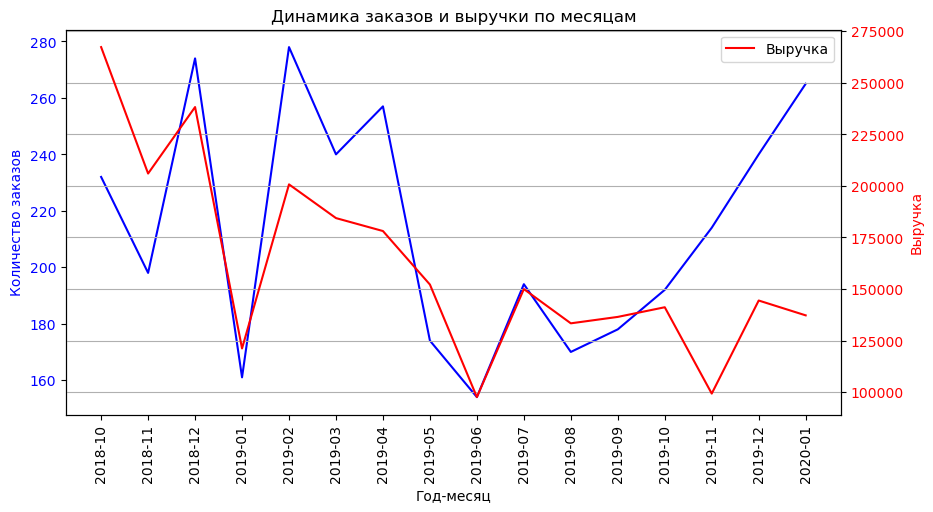

In [63]:
# Анализ сезонности
# monthly_orders = df.groupby('month')['order_id'].nunique()
# monthly_revenue = df.groupby('month')['price'].sum()
# Группировка данных по году и месяцу
df['year_month'] = pd.to_datetime(df['date']).dt.to_period('M')  # Создаем столбец с периодом года и месяца
monthly_orders = df.groupby('year_month')['order_id'].nunique()  # Группируем по году и месяцу
monthly_revenue = df.groupby('year_month')['price'].sum()
# Сортировка по году по возрастанию
monthly_orders = monthly_orders.sort_index() 
monthly_revenue = monthly_revenue.sort_index()

# Создание графика
fig, ax1 = plt.subplots(figsize=(10, 5))

# Преобразуем индекс в строковый формат для matplotlib
monthly_orders.index = monthly_orders.index.astype(str)  # Преобразуем индекс в строки
monthly_revenue.index = monthly_revenue.index.astype(str)

# Линия для количества заказов
ax1.plot(monthly_orders.index, monthly_orders.values, label='Количество заказов', color='blue')
ax1.set_xlabel('Год-месяц')
ax1.set_ylabel('Количество заказов', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
# Поворот значений на оси x (дата)
plt.xticks(rotation=90) 
# Вторая ось для выручки
ax2 = ax1.twinx()
ax2.plot(monthly_revenue.index, monthly_revenue.values, label='Выручка', color='red')
ax2.set_ylabel('Выручка', color='red')
ax2.set_ylabel('Выручка', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Настройки графика
plt.title('Динамика заказов и выручки по месяцам')
plt.grid(True)
plt.legend()

plt.show()

<u>Динамика заказов демонстрирует сезонность. Наибольшее количество заказов приходится на декабрь и февраль,  а также наблюдается небольшой пик в октябре 2018 года. В летние месяцы (июль, август) наблюдается спад в заказах. Заказы имеют тенденцию к росту в конце года, особенно в ноябре и декабре.<u> 

<u>Динамика выручки также демонстрирует сезонность,  как и заказы. Пики выручки наблюдаются в декабре, феврале и октябре 2018 года, что совпадает с пиками заказов. Летний спад также отражается в выручке. В целом, динамика выручки повторяет динамику заказов.<u>

<u>Данные свидетельствуют о сезонной динамике заказов и выручки. Повышенная активность наблюдается в декабре, феврале и октябре 2018 года,  возможно, связанная с праздничными сезонами или специфическими маркетинговыми кампаниями. Летние месяцы демонстрируют снижение активности, что может быть связано с сезонными факторами, такими как отпуска и летняя жара. Совпадение пиков заказов и выручки подтверждает, что увеличение продаж в определенные периоды года связано с увеличением количества заказов.<u>

Построим графики, чтобы посмотреть, как меняется количество заказов, выручка по дням.

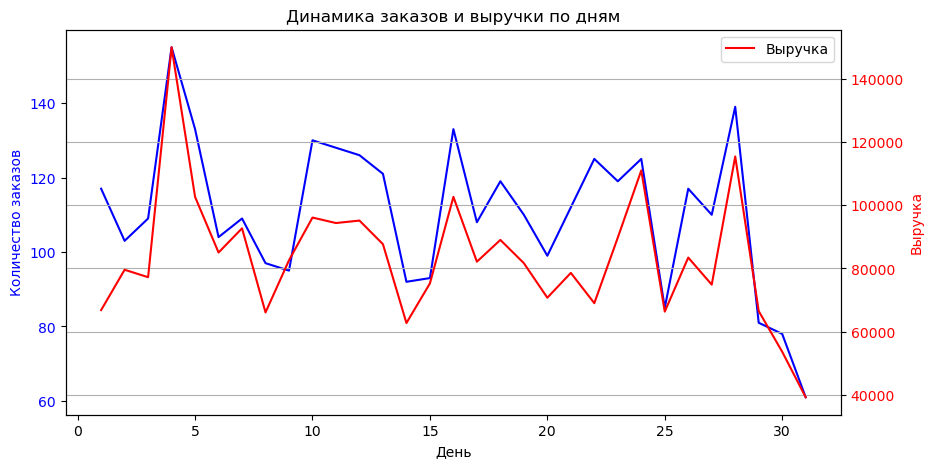

In [66]:
# Анализ сезонности
day_orders = df.groupby('day')['order_id'].nunique()
day_revenue = df.groupby('day')['price'].sum()

# Создание графика
fig, ax1 = plt.subplots(figsize=(10, 5))

# Линия для количества заказов
ax1.plot(day_orders.index, day_orders.values, label='Количество заказов', color='blue')
ax1.set_xlabel('День')
ax1.set_ylabel('Количество заказов', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Вторая ось для выручки
ax2 = ax1.twinx()
ax2.plot(day_revenue.index, day_revenue.values, label='Выручка', color='red')
ax2.set_ylabel('Выручка', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Настройки графика
plt.title('Динамика заказов и выручки по дням')
plt.grid(True)
plt.legend()
plt.show()

<u>Пики количества заказов часто наблюдаются в первой половине месяца (например, 4, 5, 11 дни).<u><br><u>Cпад наблюдается в конце месяца.
<u><br><u>Среднее количество заказов примерно 110-120 в день.<u><br><u>
Пики выручки также часто наблюдаются в начале месяца (например, 4, 5, 11, 16 дни).<u><br><u>
Спады в конце месяца (25, 29, 30, 31 дни).<u><br><u>
Средняя выручка колеблется около 90 000 рублей в день.<u><br><u>
График показывает, что динамика заказов и выручки имеют схожую тенденцию, с пиками в начале месяца и спадами в конце. <u><br><u>Это может быть связано с сезонными факторами, праздниками, или другими причинами.

Построим графики, чтобы посмотреть, как меняется количество заказов, выручка по дням недели.

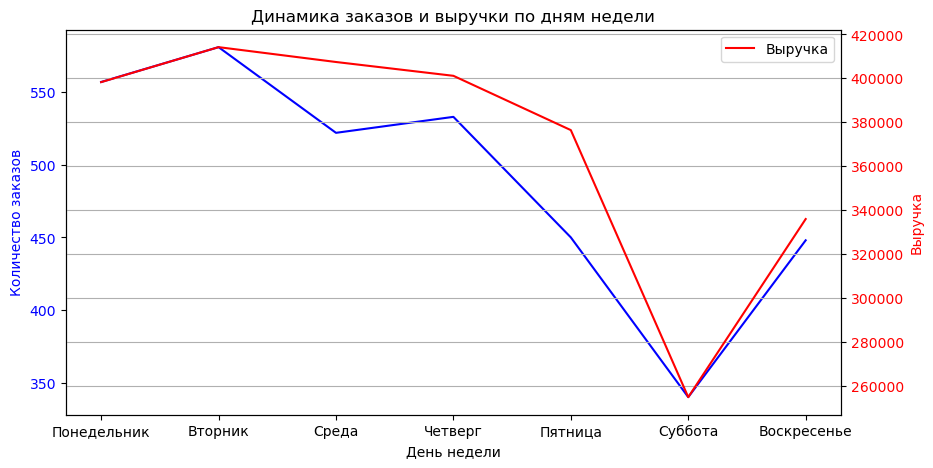

In [69]:
# Группируем данные по дням недели
day_of_week_orders = df.groupby('day_of_week')['order_id'].nunique()
day_of_week_revenue = df.groupby('day_of_week')['price'].sum()

# Определяем порядок дней недели
days = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

# Переупорядочиваем данные по дням недели
day_of_week_orders = day_of_week_orders.reindex(days)
day_of_week_revenue = day_of_week_revenue.reindex(days)

# Создание графика
fig, ax1 = plt.subplots(figsize=(10, 5))

# Линия для количества заказов
ax1.plot(day_of_week_orders.index, day_of_week_orders.values, label='Количество заказов', color='blue')
ax1.set_xlabel('День недели')
ax1.set_ylabel('Количество заказов', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Вторая ось для выручки
ax2 = ax1.twinx()
ax2.plot(day_of_week_revenue.index, day_of_week_revenue.values, label='Выручка', color='red')
ax2.set_ylabel('Выручка', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Настройки графика
plt.title('Динамика заказов и выручки по дням недели')
plt.grid()
plt.legend(loc='upper right')
plt.show()

<u>Динамика заказов и выручки по дням недели показывает, что наибольшее количество заказов и выручки наблюдается в будние дни, особенно во вторник.<u><br><u> Пик выручки приходится на вторник (468 106,5 рублей), а пик заказов - на понедельник (583 заказа).<u><br><u>Суббота и воскресенье имеют наименьшие показатели по заказам и выручке, что говорит о небольшой активности пользователей в выходные дни.

***Анализ данных о покупателях показал, что средняя стоимость покупок составляет 691.21 руб. Большинство покупателей тратят меньше средней стоимости, но есть группа покупателей с очень высокими средними чеками. Большинство покупателей совершают от 1 до 3 заказов, но есть и покупатели которые совершающие значительно больше заказов. Эти данные указывают на неоднородность клиентской базы.***

***Анализ данных о товарах показал, что большинство заказов содержат 1 товар. Заказы с большим количеством товаров встречаются редко. Это может быть связано с оптовыми покупками или особыми заказами. Лидер продаж — Пеларгония розебудная Red Pandora укорененный черенок.***  

***Анализ временных рядов по месяцам показал, что наибольшее количество заказов и выручки приходится на начало и конец года (январь, февраль, декабрь). В летние месяцы (июль, август) наблюдается спад. Данные свидетельствуют о сезонной динамике заказов и выручки. Повышенная активность наблюдается в начале и конце года, вероятно, связанная с праздничными сезонами. Летние месяцы демонстрируют снижение активности, что может быть связано с сезонными факторами, такими как отпуска и летняя жара.***

***Продажи демонстрируют сезонные колебания, с пиками в начале месяца и спадами в конце.Среднее количество заказов составляет примерно 110-120 в день, а средняя выручка — около 90 000 рублей в день. Наибольшее количество заказов и выручки наблюдается в будние дни, особенно во вторник. Наименьшая активность пользователей наблюдается в выходные дни.***

#### Кластеризация

Выделим ключевые слова из 'product' для дальнешей категоризации товаров и выведем их список

In [74]:
# Инициализация анализатора
morph = pymorphy2.MorphAnalyzer()
# Функция для извлечения первых трех существительных
def extract_nouns(text):
    # Оставляем только русские символы и пробелы
    text = re.sub(r'[^А-Яа-яЁё\s-]', '', text)
    words = text.split()  # Токенизация
    nouns = []
    for word in words:
        parsed_word = morph.parse(word)[0]  # Морфологический разбор
        if 'NOUN' in parsed_word.tag:  # Проверка на существительное
            nouns.append(word)
    return ' '.join(nouns[:1])  # Возвращаем только первые три существительных как строку

# Создание нового столбца с существительными
df['nouns'] = df['product'].apply(extract_nouns)

print(set(df.nouns))

# Удаляем столбец 'nouns'
df.drop('nouns', axis=1, inplace=True)

AttributeError: module 'inspect' has no attribute 'getargspec'

На основе полученного списка сформируем категории товаров

In [ ]:
# Функция для присвоения категорий
def assign_category(product):
    
    if any(plant in product for plant in ['Адиантум', 'Азалия', 'Аквилегия', 'Антуриум', 'Базилик', 'Лилейник','Бархатцы', 
                                          'Бегония', 'Виола', 'Альбука', 'Герань', 'Гипсофила', 'Глоксиния','Гортензия', 
                                          'Дендробиум', 'каландива', 'Калатея', 'Калибрахоа', 'Калоцефалус','Крокусы', 
                                          'Лаванда', 'Латифолия', 'Мирт', 'Молодило', 'Настурция', 'Пеларгония','Петуния', 
                                          'Примула', 'Радермахера', 'растение', 'Роза', 'Розмарин', 'Спатифиллум','Суккулент', 
                                          'Хлорофитум', 'Хризантема', 'Хризолидокарпус', 'цветок', 'Цикламен','Циперус', 
                                          'Шеффлера', 'Эвкалипт', 'Эхеверия', 'Юкка', 'Эпипремнум', 'Гиацинт','Нефролепис', 
                                          'Калла', 'Декабрист', 'Тюльпан', 'Вербена', 'Бакопа', 'Ранункулус', 'Газания', 
                                          'Овсянница', 'Лавр', 'Вербейник', 'Колокольчик', 'Котовник', ' Арабика', 'Эхинацея', 
                                          'Ясколка', 'Папоротник', 'Платикодон', 'Энотера', 'Фуксия', 'травы','Цитрофортунелла',
                                          'Пеперомия', 'Дыня', 'Синнингия', 'Гардения', 'томата', 'Львиный','Лобелия', 
                                          'Мускари', 'Пиретрум', 'Агератум', 'Колеус', 'Тагетис', 'Цинерария', 'Муррайя', 
                                          'Портулак', 'Астра', 'Аргирантерум', 'Левкой', 'Вероника', 'Целозия', 'Патиссон', 
                                          'Маттиола', 'Сальвия','Джункус', 'Драцена', 'Фация', 'Хоста', 'Смолёвка','Попсокс', 
                                          'Сакура', 'Бузульник','Камнеломка','Солидаго', 'Физостегия', 'Бадан', 'Лен', 
                                          'Амариллис', 'Мединилла', 'Замиокулькас', 'Пахира', 'Литопс', 'Земляника', 'Цинния', 
                                          'Незабудка', 'Седум', 'Нолина', 'виноград', 'Алиссум', 'Алоэ', 'Анемона', 'Аптения', 
                                          'Артемизия', 'Аспарагус', 'Афеляндра', 'Бальзам', 'Бальзамин', 'Барвинок','Валериана',
                                          'Вигна', 'Виноград', 'Гайлардия', 'Гвоздика', 'Георгина', 'Гербера','Гимнокалициум', 
                                          'Гиностемма', 'Годеция', 'Диффенбахия', 'Завертка', 'Зверобой', 'Змееголовник', 
                                          'Импатиенс', 'Иссоп', 'Кабачок', 'Каландива', 'Календула', 'Каллуна','Кампанула', 
                                          'Капсикум', 'Кипарисовик', 'Кореопсис', 'Кориандр', 'Крассула', 'Лаватера','Лантана', 
                                          'Лапчатка', 'Чабер', 'Лиана', 'Любисток', 'Мимоза', 'Нивянник', 'Осина', 
                                          'Подсолнечник', 'Пуансетия', 'Растение', 'Рудбекия', 'Сантолина', 'Скиммия', 
                                          'Буддлея','Травы', 'Табак', 'Тыква', 'Фаленопсис', 'Фатсия', 'Фиалка', 'Фикус', 
                                          'Флокс', 'Смолевка','Эхинокактус', 'Эшшольция','Горох', 'Томат', 'Укроп','Морковь', 
                                          'Огурец', 'Петрушка', 'Капуста', 'Рассада', 'Мелисса', 'Душица','Соланум', 'Салат', 
                                          'Космея ', 'Арбуз', 'Баклажан', 'Циния', 'Клубника','Лук', 'Фиттония', 'Хамедорея', 
                                          'Сельдерей','Тимьян', 'Сциндапсус', 'Монарда', 'Мята', 'Ель ', 'Пуансеттия', 
                                          ' рассада ', 'кухонные', 'Шалфей']):
        return 'Растения'
    
    elif any(tool in product for tool in ['Орехоколка', 'Миксер', 'Венчик', 'Сито',  'Тортница', 
                                          'Скалка ', 'Столовые принадлежности', 'Соковарка', 'Блюдце', 
                                          'Соковыжималка', 'Половник', 'Сахарница', 'Весы настольные','Отделитель',  
                                          'Мантоварка-Пароварка', 'стакан', 'Толкушка', 'Масленка', 'Мини-сковорода', 
                                          'Сотейник', 'Кружка', 'Бульонница', 'посуды',  'Кастрюля', 'Ковш', 'Ложка', 
                                          'Мантоварка','Форма', 'Рыбочистка', 'кружка', 'Стакан', 'Нож', 'Ножеточка', 
                                          'cалфетка ', 'Веник', 'Ведро', 'Чайник', 'Противень', 'Миска', 'фужеров',
                                          'Сковорода', 'Тарелка', 'Вилка',  'ложка', 'Лопатка', 'нож ', 'Шприц', 
                                          'Овощечистка', 'Салфетница', 'Блюдо','Кипятильник', 'Хлебница', 'Тряпка', 
                                          'скатерть',  'крышка', 'Пресс',  'Салатник', 'Маслёнка', 'Электроштопор', 
                                          'Терка', 'Кухонное полотенце', 'полотенце', 'Овощеварка', 'Чайный набор', 
                                          'Кисточка','полотенец', 'столовых', 'WEBBER', 'кружек','Контейнер', 'Салфетка', 
                                          'салфетка', 'Картофелемялка', 'салфетки ', 'бокалов', 'салфеток']):
        return 'Товары для кухни'
    
    
    elif any(tool in product for tool in [ 'Штангенциркуль', 'Сверло', 'сварка ', 'инструмент', 'угольник', 'сверел', 
                                          'напильников', 'Инструмент',  'Лестница', 'Линейка', 'Сверло-фреза']):
        return 'Инструменты'

    elif any(tool in product for tool in [ 'Полотенце', 'Наволочка', 'Простынь',   'Пододеяльник', 'Простыня', 
                                              'Плед', 'Одеяло','Покрывало', 'бельё ']):
        return 'Текстиль и белье'
    
    elif any(tool in product for tool in [ 'Ваза', 'Полка для', 'Светильник', 'Комод', 'Этажерка', 'Кувшин',  'Цветок',  
                                          'Пуф', 'Обувница', 'Подушка декоративная']):
        return 'Мебель и декор'
    
    elif any(tool in product for tool in ['Антинакипин', 'Ерш', 'Мыло', 'Мыло-Скраб', 'Мыльница', 'Ополаскиватель', 
                                          'сушилка','Мылоскраб', 'Вантуз',  'Гель', 'Фен', 'Корзина', 'Дозатор', 
                                          'Крем','Кондиционер',  'Штанга', 'маска','Швабра', 'мыло ', 'паста ', 
                                          'Щетка', 'Щетка-Сметка', 'Щетка-Утюжок', 'Ёрш', 'Таз', 'Крышка', 'Вешалка', 
                                          'Крючок', 'доска ', 'Сумкатележка',  'Котёл', 'Контейнер для ', 'METALLONI',
                                          'чехол', 'Чехол', 'Набор вешалок',    'Корзинка',  'контейнер', 'Короб', 
                                          'коробка', 'Наматрасник', 'Держатель', 'Пробка', 'Лоток', 'Вешалки','Термометр', 
                                          'Наматрацник', 'Шнур', 'Щётка', 'Щетка-утюжок', 'щетка', 'Ящик',
                                          'Тряпка для уборки',  'Ванна', 'Ткань',   'пуф', 'Пружина', 'Стяжка', 
                                          'Антижир', 'Губка', 'крем ','средство', 'доска-стремянка','биопорошок', 
                                          'ножницы', 'дерево','гель ', 'кашпо',  'пакет ', 'Ковёр', 'Бак',   'Сетка',
                                          'Сиденье', 'Скатерть','Банкa', 'Бензин', 'Блок', ' банка ',  'Весы напольные', 
                                          'Вешалка-перекладина', 'Вешалка-плечики', 'Вешалка-стойка', 'Защитный',
                                          'Вешалка-сушилка','Емкость', 'Карниз', 'Керамике', 'Подставка для', 'ковров', 
                                          'Ключница','Ковер', 'Коврик', 'Коробка', 'Корыто', 'Котел', ' халат ', 'Кофр',
                                          'Муляж', 'Наматрицник-чехол', 'Насадка', 'Насадка-моп','прищепок','Насадка-отжим',
                                          'Основание', 'Отбеливатель', 'Отжим', 'Пакет', 'Пена', 'Петля','Плечики', 
                                          'Подголовник', 'Подкладка', 'Подрукавник',  'Подставка', 'Покрытие', 'Полки', 
                                          'Прищепки', 'Искусственная','Просеиватель','Ролик', 'Рукав', 'Ручка-Скоба',  
                                          'Стремянк', 'Сумка', 'Сумка-тележка', 'Сушилка', ' насадка','Тележка', 'Урна',
                                          'Урна-Пепельница',  'Экран', ' вешалок',  'Банка', 'белье ', 'Бельевые', 
                                          'Биопорошок', 'Веревка', 'Вкладыши','Дерево', 'Тряпкодержатель', 'Измельчитель', 
                                          'Кашпо','Клен', 'Клик', 'Vileda', 'Кодонанта', 'Кольца',  'Комплект', 
                                          'Композиция','Крепеж', 'Ручка', 'Кэнди', 'Лист','Ножницы', 'оксид', 'Паста', 
                                          'Перчатки','Пылесос', 'Пьезозажигалка', 'Рассекатель', 'Решетка', 'Скалка', 
                                          'Скребок',  'Сметка', 'Совок', 'Средство', 'Термокружка', 'Термос',
                                          'Термостакан', 'Утюг', 'Фал ','Фиксатор-шар', 'Пружина', 'Фоторамка', 'Халат',  
                                          'Стяжки', 'Шило', 'Шпагат', 'Штора','соль', 'Доска', 'Окномойка', 'Стеллаж', 
                                          'Бидон', 'Верёвка', 'Фиксатор','Шпингалет', 'блок', 'Уголок', 'Концентрат', 
                                          'Мешок', 'Декоративная', 'Подушка' ]):
        return 'Хозяйственные товары'

    

# Присваиваем категории
df['category'] = df['product'].apply(assign_category)


df.loc[df['product'].str.contains('в горшке|Муляж', regex=True), 'category'] = 'Хозяйственные товары'
df.loc[df['product'].str.contains(' г |Р-9') & (df['category'] == 'Растения'), 'category'] = 'Семена'
df.loc[df['product'].str.contains('Подарочный набор на 8', regex=True), 'category'] = 'Подарочный набор на 8 марта'

Провевим наличие товоров без категории

In [ ]:
df[df['category'].isnull()]

Проверим наличие категорий

In [ ]:
df.category.unique()

In [ ]:
# Группируем данные по категориям и подсчитываем количество товаров
category_counts = df['category'].value_counts()

# Уникальное количество категорий для цветовой палитры
unique_categories_count = len(category_counts.index)

# Устанавливаем цвет
colors = sns.color_palette('viridis', n_colors=unique_categories_count) # Используем палитру 'viridis'

# Строим гистограмму
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts.index, category_counts.values, color=colors) # Сохраняем объект баров

plt.title('Распределение товаров по категориям')
plt.xlabel('')
plt.ylabel('Количество товаров')
plt.xticks(rotation=90) # Поворачиваем метки оси X для удобства чтения
plt.grid(axis='y')

# Добавление легенды с правильными метками
plt.legend(bars, ['{}'.format(category) for category in category_counts.index], title="Категории:")

# Добавление подписей к столбцам
for i, v in enumerate(category_counts):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.show()

По итогам разделения товаров на категории выделили следующие 8 групп: 

`Растения` - 2 698 едениц; 

`Хозяйственные товары` - 2 210 едениц;

`Товары для кухни` - 337 едениц;

`Семена` - 71 еденица; 

`Мебель и декор` - 43 еденицы;  

`Инструменты` - 34 еденицы;  

`Текстиль и бельеи` - 24 еденицы;  

`Подарочный набор на 8 марта` - 7 едениц.

Разделим покупателей на группы, используя `KMeans` по 4 параметрам

In [ ]:
# Подготовка данных

df['total_price'] = df['quantity'] * df['price']

customer_data = df.groupby('customer_id').agg( 
    average_purchase_frequency=('order_id', 'nunique'),  # Средняя частота покупок
    average_quantity=('quantity', 'mean'),  # Среднее количество купленного товара
    average_price=('price', 'mean'),  # Средняя цена товара
    average_purchase_amount=('total_price', 'mean')  # Средняя стоимость заказа
).reset_index()

# Создание матрицы признаков
X = customer_data[['average_purchase_amount', 'average_purchase_frequency', 'average_quantity', 'average_price']]

# Нормализация данных с помощью MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Списки для хранения значений SSE и коэффициента силуэта
sse = []
silhouette_scores = []

# Определение максимального количества кластеров
max_k = 15

# Проверка различных значений k
for k in range(2, max_k + 1):  # Начинаем с 2, так как 1 кластер не имеет смысла
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Метод локтя
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), sse, marker='o')
plt.title('Метод локтя (SSE)')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов ошибок (SSE)')
plt.xticks(range(2, max_k + 1))
plt.grid()

# Коэффициент силуэта
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.xticks(range(2, max_k + 1))
plt.grid()

plt.tight_layout()
plt.show()

# Определение оптимального количества кластеров по методу силуэта
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 из-за смещения индекса

# Кластеризация с помощью KMeans с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(X_scaled)

# Добавление номера кластера к DataFrame
customer_data['cluster'] = kmeans.labels_

# Добавление номера кластера к исходному датафрейму df
df = df.merge(customer_data[['customer_id', 'cluster']], on='customer_id', how='left')

print(f'Оптимальное количество кластеров: {optimal_k}')

In [ ]:
# Создаем сводную таблицу с количеством клиентов в каждом кластере
cluster_counts = customer_data['cluster'].value_counts().sort_index()  # Сортируем по индексу

# Для переопределения индексов
new_index = range(len(cluster_counts))  # Создаем новый индекс
cluster_counts.index = new_index  # Задаем новый индекс

# Определяем количество уникальных кластеров
unique_clusters_count = cluster_counts.shape[0]

# Создаем круговую диаграмму с выделением границ
plt.figure(figsize=(10, 5))  # Увеличиваем размер диаграммы для лучшей читаемости
colors = sns.color_palette('viridis', n_colors=unique_clusters_count)  # Устанавливаем цвет
wedges, texts = plt.pie(cluster_counts, startangle=90, wedgeprops={'linewidth': 3, 'edgecolor': 'white'}, 
                        colors=colors)

# Добавляем значения снаружи диаграммы
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2.0  # Находим угол для размещения текста
    x = wedge.r * 1.1 * np.cos(np.radians(angle))  # Увеличиваем радиус для размещения текста
    y = wedge.r * 1.1 * np.sin(np.radians(angle))  # Увеличиваем радиус для размещения текста
    plt.text(x, y, f'{cluster_counts[i]}', ha='center', va='center', fontsize=12)

# Добавляем легенду с названиями кластеров (переопределяем индексы в легенде)
plt.legend(title="Кластер:", labels=new_index, loc="upper right") 

plt.title('Распределение количества клиентов по группам')
plt.axis('equal') 
plt.show()

На круговой диаграмме представлено распределение  2368 клиентов по трем кластерам, определенным в результате кластерного анализа.  
* **Кластер 0** -  1 894 клиентов ( 80% от общего числа). 
* **Кластер 1** -  128   клиентов ( 5% от общего числа).
* **Кластер 2** -  346   клиентов ( 15% от общего числа).

График показывает, что  **Кластер 0** является самым крупным кластером, далее идет **Кластер 2** и наименьшее количество клиентов в **Кластер 1**. 


<u>Анализ показал, что клиенты могут быть разделены на три кластера, которые отличаются по своим размерам.  Самый большой кластер (Кластер 0) содержит 80% всех клиентов, за ним следуют Кластер 2 (15%) и Кластер 1 (5%).<u>

<u>Эти кластеры могут быть использованы для более глубокого понимания поведения клиентов, а также для разработки эффективных маркетинговых стратегий, направленных на разные группы.<u>

<u>Например, для клиентов из Кластера 0 можно использовать массовые маркетинговые кампании, в то время как для клиентов из Кластера 1, вероятно, потребуется более индивидуальный подход.<u> 

#### Визуализация сегментов

In [ ]:
# Подсчитываем количество покупок в каждом кластере
cluster_counts = df['cluster'].value_counts().sort_index()

# Определяем количество уникальных кластеров
unique_clusters_count = len(cluster_counts)

# Устанавливаем цвет 
colors = sns.color_palette('viridis', n_colors=unique_clusters_count)  

# Строим гистограмму

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color=colors) # Сохраняем объект баров

plt.title('Распределение покупок по группам клиентов')
plt.xlabel('Группы пользователей')
plt.ylabel('Количество покупок')
plt.xticks(cluster_counts.index.astype(int), rotation=0)  # Вот тут добавили .astype(int)
plt.grid(axis='y')

# Добавление легенды с правильными метками
plt.legend(bars, ['{}'.format(cluster) for cluster in cluster_counts.index], title="Кластеры:")

# Добавление подписей к столбцам
for i, v in enumerate(cluster_counts):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.show()

Гистограмма показывает распределение покупок по трем кластерам покупателей.  Видим, что **Кластер 0 является доминирующим** с более чем 4800 покупками, что значительно больше, чем у остальных кластеров.  **Кластер 2** занимает второе место с около 500 покупками, а **Кластер 1 - самый маленький**, с всего 148 покупками.

In [ ]:
# Группировка данных по кластеру и категории
cluster_category_counts = df.groupby(['cluster', 'category'])['order_id'].count().reset_index()

# Сортировка по количеству покупок (product_id)
cluster_category_counts = cluster_category_counts.sort_values(by=['cluster', 'order_id'], ascending=[True, False])

# Фильтрация для отображения только 3-х лучших категорий по каждому кластеру
top_categories = cluster_category_counts.groupby('cluster').head(3)

# Создание таблицы для графика
plot_data = top_categories.groupby(['cluster', 'category'])['order_id'].sum().reset_index()

# Построение гистограммы
plt.figure(figsize=(10, 6))

# Создание подграфиков для каждого кластера
ax = sns.barplot(x='category', y='order_id', hue='cluster', data=plot_data, palette='viridis')

# Добавление сетки
plt.grid(True)

# Настройка графиков
plt.title('Распределение топ 3 самых популярных товаров по группам клиентов')
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.xticks(rotation=0)
plt.legend(title='Кластер:')
plt.tight_layout()

# Добавление надписей о количестве покупок
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()

* **Кластер 0:**  Самые популярные товары -  `Растения`, `Хозяйственные товары` и `Товары для кухни`.  Это может указывать на то, что в кластере 0 покупатели склонны делать покупки для дома и сада.


* **Кластер 1:**  `Хозяйственные товары`  также лидируют в этом кластере, но  `Растения`  уже на втором месте,  а  `Товары для кухни`  на третьем.


* **Кластер 2:**  `Хозяйственные товары`  по-прежнему занимают первое место,  за ними следуют  `Растения`  и  `Товары для кухни`. 

In [ ]:
# Группируем данные по кластеру и категории, чтобы посчитать средний чек
average_check_by_cluster_category = df.groupby(['cluster', 'category'])['total_price'].mean().reset_index()

# Преобразуем данные в таблицу для heatmap
heatmap_data = average_check_by_cluster_category.pivot(index='category', columns='cluster', values='total_price')  # Поменяли местами index и columns

# Строим heatmap
plt.figure(figsize=(10, 6)) 
sns.heatmap(heatmap_data, annot=True, cmap='Greens', fmt='.2f', linewidths=0.5)

# Устанавливаем заголовки 
plt.xlabel('Кластер')
plt.ylabel('')
plt.title('Средний чек групп клиентов по категориям товаров')
plt.tight_layout()
plt.show()

* **Кластер 0:**  В этом кластере самый высокий средний чек в категориях `Текстиль и белье`  и  `Товары для кухни`.  Возможно,  эти  люди  склонны  к  более  дорогим  покупкам  в  этих  категориях. Например,  они  могут  покупать  дорогие  комплекты  постельного  белья  или  избирательно  подходить  к  выбору  кухонной  техники. 


* **Кластер 1:**  В  этом  кластере  самый  высокий  средний  чек  в  категории  `Подарочный набор на 8 марта`.  Может  быть,  в  этом  кластере  больше  женщин,  которые  делают  покупки  к  8  марту,  и  они  склонны  к  более  дорогим  подаркам. 


* **Кластер 2:**  В  этом  кластере  наблюдается  более  равномерный  средний  чек  по  категориям.  Возможно,  эти  люди  делают  покупки  более  разнообразные  и  не  концентрируются  на  какой-то  определенной  категории.  

In [ ]:
# Создаем столбец с периодом года и месяца
df['year_month'] = pd.to_datetime(df['date']).dt.to_period('M')  
# Группируем данные по году-месяцу, категории и кластеру
seasonal_data = df.groupby(['year_month', 'category', 'cluster'])['order_id'].nunique().reset_index() # Используем nunique

# Преобразуем 'year_month' в формат даты
seasonal_data['year_month'] = seasonal_data['year_month'].dt.to_timestamp()

# Выбираем данные для кластера 0
cluster_data = seasonal_data[seasonal_data['cluster'] == 0]

# Находим топ-3 категории по количеству заказов
top_categories = cluster_data.groupby('category')['order_id'].sum().nlargest(3).index

# Фильтруем данные только по топ-3 категориям
top_cluster_data = cluster_data[cluster_data['category'].isin(top_categories)]

# Создаём график
fig, ax = plt.subplots(figsize=(10, 6)) # Увеличил размер графика, чтобы было удобнее смотреть

# Рисуем линии для каждой категории в кластере 0
for category in top_cluster_data['category'].unique():
    category_data = top_cluster_data[top_cluster_data['category'] == category]
    ax.plot(category_data['year_month'], category_data['order_id'], label=f'{category}')

# Настраиваем график
ax.set_xlabel('Год-Месяц')
ax.set_ylabel('Количество заказов')
ax.set_title(f'Сезонность товаров по категориям для Кластера 0')
ax.grid(True)
ax.tick_params(axis='x', rotation=0) # Повернул метки оси x на 45 градусов для удобства чтения

# Добавляем легенду справа от графика
ax.legend(loc='center left', bbox_to_anchor=(1, 0.92))

plt.show()

**На графике распределения сезонности товаров для Кластера 0:**

`Растения`:  Заказы на растения распределены  неравномерно,  с пиками в апреле, мае и сентябре.  Вероятно, это связано с садовым сезоном.  В июле-августе наблюдается небольшой спад, что может быть связано с жаркой погодой или отпусками.

`Товары для кухни:` Наибольшее количество заказов  наблюдается  в марте-апреле и сентябре-октябре.  Возможно, это связано с праздничным сезоном и приготовлениями к нему. Летом же наблюдается спад - люди, возможно, больше времени проводят на улице,  и готовят меньше дома. 

`Хозяйственные товары:` Заказы на хозяйственные товары  имеют  четкий пик в декабре-январе. Люди, видимо, активно готовятся к новогодним праздникам. Летом же наблюдается спад - возможно, люди больше времени проводят на улице,  и уборка  дома отходит на второй план. 

**Дополнительные наблюдения:** 

-  В ноябре наблюдается небольшое снижение заказов на `Растения`,   возможно, люди уже заканчивают садоводство к этому времени.

In [ ]:
# Выбираем данные для кластера 1
cluster_data = seasonal_data[seasonal_data['cluster'] == 1]

# Находим топ-3 категории по количеству заказов
top_categories = cluster_data.groupby('category')['order_id'].sum().nlargest(3).index

# Фильтруем данные только по топ-3 категориям
top_cluster_data = cluster_data[cluster_data['category'].isin(top_categories)]

# Создаём график
fig, ax = plt.subplots(figsize=(10, 6)) # Увеличил размер графика, чтобы было удобнее смотреть

# Рисуем линии для каждой категории в кластере 1
for category in top_cluster_data['category'].unique():
    category_data = top_cluster_data[top_cluster_data['category'] == category]
    ax.plot(category_data['year_month'], category_data['order_id'], label=f'{category}')

# Настраиваем график
ax.set_xlabel('Год-Месяц')
ax.set_ylabel('Количество заказов')
ax.set_title(f'Сезонность товаров по категориям для Кластера 1')
ax.grid(True)
ax.tick_params(axis='x', rotation=0) # Повернул метки оси x на 45 градусов для удобства чтения

# Добавляем легенду справа от графика
ax.legend(loc='center left', bbox_to_anchor=(1, 0.93))

plt.show()

**На графике распределения сезонности товаров для Кластера 1:**

`Растения`: Заказы на растения демонстрируют явную сезонность. Пики заказов наблюдаются в марте-апреле, сентябре и октябре. В июле-августе заметен спад. Вероятно, это связано с садовыми работами и посадкой растений весной и осенью, а летом люди больше времени проводят на отдыхе.

`Товары для кухни`: Спрос на товары для кухни также имеет сезонность, но менее  выраженную, чем на растения. Пики заказов приходятся на март-апрель и сентябрь-октябрь. Спад наблюдается в июне-июле. Возможно, это связано с сезонными отпусками и выездами на природу, когда люди меньше готовят дома.

`Хозяйственные товары`: Спрос  на  хозяйственные  товары  более  неравномерен. Пики заказов приходятся на декабрь-январь и сентябрь-октябрь, вероятно, это связано с предпраздничной уборкой. Спад наблюдается в июне-июле.

**Дополнительные  наблюдения:**

-  Заказы  на `Растения`  более  равномерны  в  течение  года,  чем  заказы  на  `Товары  для  кухни`  и  `Хозяйственные  товары`.  
-  Спад  в  заказах  на  "Товары  для  кухни"  в  июне-июле  может  быть  связан  с  тем,  что  люди  больше  времени  проводят  на  улице  и  реже  готовят  дома. 
-  Спад в  заказах  на  `Хозяйственные  товары` в  июне-июле  может  быть  связан  с  тем,  что  люди  меньше  времени  проводят  дома  и  уборка  отходит  на  второй  план. 

In [ ]:
# Выбираем данные для кластера 2
cluster_data = seasonal_data[seasonal_data['cluster'] == 2]

# Находим топ-3 категории по количеству заказов
top_categories = cluster_data.groupby('category')['order_id'].sum().nlargest(3).index

# Фильтруем данные только по топ-3 категориям
top_cluster_data = cluster_data[cluster_data['category'].isin(top_categories)]

# Создаём график
fig, ax = plt.subplots(figsize=(10, 6)) # Увеличил размер графика, чтобы было удобнее смотреть

# Рисуем линии для каждой категории в кластере 2
for category in top_cluster_data['category'].unique():
    category_data = top_cluster_data[top_cluster_data['category'] == category]
    ax.plot(category_data['year_month'], category_data['order_id'], label=f'{category}')

# Настраиваем график
ax.set_xlabel('Год-Месяц')
ax.set_ylabel('Количество заказов')
ax.set_title(f'Сезонность товаров по категориям для Кластера 2')
ax.grid(True)
ax.tick_params(axis='x', rotation=0) # Повернул метки оси x на 45 градусов для удобства чтения

# Добавляем легенду справа от графика
ax.legend(loc='center left', bbox_to_anchor=(1, 0.92))

plt.show()

**На графике распределения сезонности товаров для Кластера 2:**

`Растения`: Заказы на растения демонстрируют  явную сезонность, но не столь  выраженную,  как  в  предыдущем  кластере.  Пики  заказов  наблюдаются  в марте-апреле,  сентябре  и октябре.   В июле-августе заметен спад. Вероятно,  это  связано  с  садовыми  работами  и  посадкой  растений  весной  и  осенью,  а  летом  люди  больше  времени  проводят  на  отдыхе.

`Товары для кухни`:  Спрос на товары для кухни  также  имеет  сезонность,  но  менее  выраженную,  чем  на  растения. Пики  заказов  приходятся  на март-апрель  и сентябрь-октябрь. Спад  наблюдается  в июне-июле.  Возможно,  это  связано  с  сезонными  отпусками  и  выездами  на  природу,  когда  люди  меньше  готовят  дома.

`Хозяйственные товары`: Спрос  на  хозяйственные  товары  более  неравномерен. Пики  заказов  приходятся  на декабрь-январь и сентябрь-октябрь,  вероятно,  это  связано  с  предпраздничной  уборкой. Спад  наблюдается  в июне-июле.

**Дополнительные  наблюдения:**

-  Заказы  на  `Растения`  более  равномерны  в  течение  года,  чем  заказы  на  `Товары  для  кухни`  и  `Хозяйственные  товары`.  
-  Спад  в  заказах  на  `Товары  для  кухни`  в  июне-июле  может быть  связан  с  тем,  что  люди  больше  времени  проводят  на  улице  и  реже  готовят  дома. 
-  Спад  в  заказах  на  `Хозяйственные  товары`  в  июне-июле  может  быть  связан  с  тем,  что  люди  меньше  времени  проводят  дома  и  уборка  отходит  на  второй  план. 

<a id='section_id4'></a>

### Вывод

<u>Анализ сегментов показал, что в нашем магазине есть три группы покупателей, которые отличаются по своим покупкам и сезонным предпочтениям.<u> 

- **Кластер 0** - самая большая группа покупателей (более 4800 покупок), делающая ставку на товары для дома и сада. Они наиболее активны в начале и конце года, особенно интересуются растениями и хозяйственными товарами.

    
- **Кластер 2** - вторая по величине группа (около 500 покупок), предпочитающая разнообразные покупки с сезонными пиками в мае-июне и сентябре-октябре.
 
    
- **Кластер 1** - самая маленькая группа (148 покупок), с наибольшим интересом к хозяйственным товарам и  подаркам.

<u>В каждом кластере  наблюдаются разные  сезонные предпочтения,  что может быть связано с различными потребностями и  интересами покупателей.<u> 

<u>Средний чек в разных кластерах также отличается, что может быть связано с  разным  уровнем дохода,  склонностью к более дорогим покупкам или  специфическими потребностями.<u> 

<a id='section_id5'></a>

## Проверка гипотез

Для выбором теста проверим данные на нормальность распределения

In [ ]:
# Проверяем нормальность распределения для каждого столбца
for column in ['average_purchase_frequency', 'average_price']:
    # Проверяем нормальность с помощью теста Шапиро-Уилка
    statistic, pvalue = stats.shapiro(customer_data[column])
    print(f"Тест Шапиро-Уилка для '{column}':")
    print(f"Статистика: {statistic:.2f}, p-значение: {pvalue:.2f}")

    # Если p-значение < 0.05, то распределение не является нормальным
    if pvalue < 0.05:
        print(f"Распределение '{column}' НЕ является нормальным.")
    else:
        print(f"Распределение '{column}' является нормальным.")
    print("-----------------------------------------")

<u>Проведенные тесты Шапиро-Уилка показали,  что ни один из трех исследуемых параметров - 'Количество дней с последней покупки',  'Количество покупок',  'Общая сумма покупок' - не имеет нормального распределения.<u>  

<u>Это означает,  что  нам  необходимо использовать непараметрические методы анализа для сравнения  групп по  этим параметрам.<u>  

<u>Например,  для сравнения групп по 'количеству дней с последней покупки' можно использовать тест Манна-Уитни.<u>  

Проверим нулевую и альтернативную гипотезу

**Нулевая гипотеза (H0):** Нет статистически значимых различий в средних значениях метрик (средняя сумма покупки и частота покупок) между сегментами покупателей.

**Альтернативная гипотеза (H1):** Есть статистически значимые различия в средних значениях метрик (средняя сумма покупки и частота покупок) между сегментами покупателей.

Уровень значимости определим как alpha = 0.05.

In [ ]:
# Создаем список всех пар кластеров
cluster_pairs = [
    (0, 1),
    (0, 2),
    (1, 2)
]

# # Уровень значимости с поправкой Бонферрони
# alpha = 0.05 / 3

# Уровень значимости для метода Шидака 
alpha = 1 - (1 - 0.05) ** (1/3) 

# Цикл по всем парам кластеров
for cluster_1, cluster_2 in cluster_pairs:
    # Фильтруем данные по кластерам
    cluster_data_1 = customer_data[customer_data['cluster'] == cluster_1]
    cluster_data_2 = customer_data[customer_data['cluster'] == cluster_2]

    # Проводим тест Манна-Уитни для средней суммы покупки
    u_stat_sum, p_value_sum = mannwhitneyu(cluster_data_1['average_price'], cluster_data_2['average_price'])

    # Проводим тест Манна-Уитни для частоты покупок
    u_stat_freq, p_value_freq = mannwhitneyu(cluster_data_1['average_purchase_frequency'], cluster_data_2['average_purchase_frequency'])

    # Выводим результаты
    print(f"Тест Манна-Уитни для кластеров {cluster_1} и {cluster_2}:")
    
    # Результаты для средней суммы покупок
    print("Средняя сумма покупок:")
    print(f"Статистика U: {u_stat_sum:.2f}, p-значение: {p_value_sum:.4f}")
    
    # Сравнение p-значения с уровнем значимости
    if p_value_sum < alpha:
        print("Разница статистически значима")
    else:
        print("Разница не статистически значима")
    
    # Результаты для частоты покупок
    print("Частота покупок:")
    print(f"Статистика U: {u_stat_freq:.2f}, p-значение: {p_value_freq:.4f}")
    
    # Сравнение p-значения с уровнем значимости
    if p_value_freq < alpha:
        print("Разница статистически значима")
    else:
        print("Разница не статистически значима")
    
    print("-" * 30)

<a id='section_id6'></a>

### Вывод

<u>По рузультам проведенного анализа с помощью теста Манна-Уитни отвергаем нулевую гипотезу (H0) и принимаем альтернативную гипотезу (H1) для большинства парных сравнений между кластерами.<u> 

<u>Между кластерами 0 и 1, а также кластерами 1 и 2, наблюдаются статистически значимые различия в средних значениях как средней суммы покупок, так и частоты покупок.<u> 

<u>Однако между кластерами 0 и 2 статистически значимые различия выявлены только для средней суммы покупок, в то время как для частоты покупок различия не были обнаружены.<u>

<u>Эти результаты свидетельствуют о том, что большинство кластеров действительно отличаются друг от друга по поведенческим паттернам, за исключением частоты покупок у кластеров 0 и 2.<u>

<a id='section_id7'></a>

## Создание профилей покупателей

#### Опишем каждый сегмент с учетом их потребностей и характеристик, а также добавим рекомендации.

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

**Кластер 0: "Домашние садоводы"**

**Описание:**

* Размер сегмента: 1 894 клиента (80% от общего числа).
* Средняя частота покупок: 1.5 покупки в месяц.
* Среднее количество товара в заказе: 1.5 едениц.
* Средняя цена товара: 394 рубля.
* Средний чек: 488 рублей.
* Популярные товары: `Растения`, `Хозяйственные товары`, `Товары для кухни`.

**Сезонность:**

* **Растения:** Пики заказов наблюдаются в апреле, мае и сентябре, что, вероятно, связано с садовым сезоном. В июле-августе наблюдается небольшой спад, что может быть связано с жаркой погодой или отпусками.  В ноябре наблюдается небольшое снижение заказов на растения, вероятно, люди уже заканчивают садоводство к этому времени.
* **Товары для кухни:**  Наибольшее количество заказов наблюдается в марте-апреле и сентябре-октябре. Возможно, это связано с праздничным сезоном и приготовлениями к нему. Летом же наблюдается спад - люди, возможно, больше времени проводят на улице, и готовят меньше дома.
* **Хозяйственные товары:** Заказы на хозяйственные товары имеют четкий пик в декабре-январе, что говорит о том, что люди активно готовятся к новогодним праздникам. Летом же наблюдается спад - возможно, люди больше времени проводят на улице, и уборка дома отходит на второй план.

**Потребности:**

* **Качество:** Ищут качественные товары для дома и сада.
* **Удобство:** Ожидают возможности купить все необходимое в одном месте.
* **Разнообразие:** Предпочитают иметь возможность покупать как растения, так и хозяйственные товары и товары для кухни.
* **Информационная поддержка:** Могут нуждаться в советах по уходу за растениями, выборе товаров для дома и сада.

**Характеристики:**

* **Домохозяйства:** С большой вероятностью покупают для дома и сада.
* **Сезонные покупатели:** Их потребности меняются в зависимости от времени года.
* **Средне-высокий бюджет:** Готовы потратить приличную сумму на товары для дома и сада.

**Дополнительные наблюдения:**

* Высокий средний чек в категориях `Текстиль и белье` и `Товары для кухни` указывает на то, что они предпочитают более дорогие товары в этих категориях. Возможно, они приобретают дорогие комплекты постельного белья или качественную кухонную технику.
* Доминирующий сегмент: Составляет 80% от общего числа клиентов, что делает его важным для бизнеса.

**Рекомендации:**

* **Специальные предложения по сезонам:**  например, скидки на семена в начале сезона, акции на хозяйственные товары зимой, а также акции на растения в апреле, мае и сентябре, чтобы стимулировать покупки в пиковые сезоны.
* **Комплексные предложения:** Предложить наборы, включающие растения, хозяйственные товары и товары для кухни, особенно в период подготовки к праздникам (например, набор для весенней посадки, набор для новогоднего стола).
* **Индивидуальный подход:** Используйте данные о покупках, чтобы предлагать релевантные товары и услуги в зависимости от времени года и предпочтений клиента. Например, в апреле можно предлагать клиентам,которые покупали растения, товары для ухода за ними, а в декабре - предлагать клиентам, которые покупали хозяйственные товары, новогодние товары.

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

**Кластер 1: "Домохозяйства с разносторонними потребностями"**

**Описание:**

* Размер сегмента: 128 клиентов (5% от общего числа).
* Средняя частота покупок: 1 покупка в месяц.
* Среднее количество товара в заказе: 14 едениц.
* Средняя цена товара: 138 рублей.
* Средний чек: 1 852 рубля.
* Популярные товары: `Хозяйственные товары`, `Растения`, `Товары для кухни`.

**Сезонность:**

* **Растения:**  Заказы на растения демонстрируют явную сезонность. Пики заказов наблюдаются в марте-апреле, сентябре и октябре. В июле-августе заметен спад. Вероятно, это связано с садовыми работами и посадкой растений весной и осенью, а летом люди больше времени проводят на отдыхе.
* **Товары для кухни:** Спрос на товары для кухни также имеет сезонность, но менее выраженную, чем на растения. Пики заказов приходятся на март-апрель и сентябрь-октябрь. Спад наблюдается в июне-июле. Возможно, это связано с сезонными отпусками и выездами на природу, когда люди меньше готовят дома.
* **Хозяйственные товары:** Спрос на хозяйственные товары более неравномерен. Пики заказов приходятся на декабрь-январь и сентябрь-октябрь, вероятно, это связано с предпраздничной уборкой. Спад наблюдается в июне-июле.

**Потребности:**

* **Качество:** Ищут качественные товары для дома и сада.
* **Удобство:** Ожидают возможности купить все необходимое в одном месте.
* **Разнообразие:** Покупают как растения,так и хозяйственные товары и товары для кухни.
* **Сезонность:** Активно делают покупки в периоды пикового спроса на разные категории.

**Характеристики:**

* **Домохозяйства:** С большой вероятностью покупают для дома и сада.
* **Сезонные покупатели:** Их потребности меняются в зависимости от времени года.
* **Средне-высокий бюджет:** Готовы потратить приличную сумму на товары для дома и сада.
* **Активные покупатели:** Средняя частота покупок близка к средней по всем клиентам.

**Дополнительные наблюдения:**

* Высокий средний чек в категории `Подарочный набор на 8 марта` указывает на то, что в этом сегменте может быть большая доля женщин, делающих покупки к 8 марту и склонных к более дорогим подаркам.
*  Заказы на Растения более равномерны в течение года, чем заказы на `Товары для кухни` и `Хозяйственные товары`.
* Спад в заказах на `Товары для кухни` в июне-июле может быть связан с тем, что люди больше времени проводят на улице и реже готовят дома.
* Спад в заказах на Хозяйственные товары в июне-июле может быть связан с тем, что люди меньше времени проводят дома и уборка отходит на второй план.
* Маленький сегмент: Составляет 5% от общего числа клиентов, что делает его менее значимым, чем предыдущий.

**Рекомендации:**

* **Акции и скидки по сезонам:**  Предлагать скидки на растения в марте-апреле, сентябре и октябре, на товары для кухни в марте-апреле и сентябре-октябре, на хозяйственные товары в декабре-январе и сентябре-октябре. 
* **Индивидуальный подход:** Используйте данные о покупках, чтобы предлагать релевантные товары и услуги в зависимости от времени года и предпочтений клиента.  Например, в марте можно предложить клиентам, которые покупали растения, товары для садоводства, а в декабре - предложить клиентам, которые покупали хозяйственные товары,  новогодние товары.
* **Программы лояльности:** Можно создать специальную программу лояльности для этого сегмента, которая бы мотивировала их делать покупки регулярно. Например,  предоставлять скидки на следующий заказ после покупки определенного количества товаров или предлагать бонусы за определенную сумму покупок. 
* **Комплексные предложения:**  Создайте комплексные предложения, которые бы учитывали потребности этого сегмента в разные периоды года. Например, в марте-апреле можно предложить набор для садоводства, а в декабре-январе - набор для новогодней уборки.

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

**Кластер 2: "Домохозяйства с устойчивым спросом"**

**Описание:**

* Размер сегмента: 346 клиентов (15% от общего числа).
* Средняя частота покупок: 1.41 покупки в месяц.
* Среднее количество товара в заказе: 1.10 единиц.
* Средняя цена товара: 2 158 рублей.
* Средний чек: 2 379 рублей.
* Популярные товары: `Хозяйственные товары`, `Растения`, `Товары для кухни`.

**Сезонность:**

* **Растения:** Пики заказов наблюдаются в марте-апреле, сентябре и октябре. В июле-августе заметен спад.  Вероятно, это связано с садовыми работами и посадкой растений весной и осенью, а летом люди больше времени проводят на отдыхе.
* **Товары для кухни:** Спрос на товары для кухни также имеет сезонность, но менее выраженную, чем на растения. Пики заказов приходятся на март-апрель и сентябрь-октябрь. Спад наблюдается в июне-июле. Возможно, это связано с сезонными отпусками и выездами на природу, когда люди меньше готовят дома.
* **Хозяйственные товары:** Спрос на хозяйственные товары более неравномерен. Пики заказов приходятся на декабрь-январь и сентябрь-октябрь, вероятно, это связано с предпраздничной уборкой. Спад наблюдается в июне-июле.

**Потребности:**

* **Качество:** Ожидают качественные товары для дома и сада.
* **Доступность:** Важно, чтобы необходимые товары были в доступности в нужное время.
* **Разнообразие:** Заказывают разные категории товаров, не концентрируясь на одной.
* **Сезонность:** Активно делают покупки в периоды пикового спроса, но спрос более стабилен, чем в предыдущем сегменте.

**Характеристики:**

* **Домохозяйства:**  С большой вероятностью покупают для дома и сада.
* **Сезонные покупатели:**  Их потребности меняются в зависимости от времени года, но менее выражено, чем в первом сегменте.
* **Средне-высокий бюджет:**  Готовы потратить приличную сумму на товары для дома и сада.
* **Более активные покупатели:**  Средняя частота покупок выше средней по всем клиентам.

**Дополнительные наблюдения:**

* **Средний чек более равномерен по категориям - это может указывать на более разнообразные потребности покупателей из этого сегмента.**
* **Заказы на `Растения` более равномерны в течение года, чем заказы на `Товары для кухни` и `Хозяйственные товары`.**

**Рекомендации:**

* **Предложения по сезонам:**
    * Предлагать скидки и акции на растения в марте-апреле, сентябре и октябре.
    * Предлагать скидки и акции на товары для кухни в марте-апреле и сентябре-октябре.
    * Предлагать скидки и акции на хозяйственные товары в декабре-январе и сентябре-октябре.
* **Скидки на комплексные покупки:**  Могут быть интересны скидки на покупку нескольких товаров из разных категорий.
* **Программа лояльности:**  Можно создать программу лояльности, которая бы предоставляла бонусы за покупки в разных категориях или за регулярные покупки в течение года.
* **Расширение ассортимента:**  Важно обеспечить достаточный ассортимент товаров, чтобы удовлетворить разнообразные потребности этого сегмента.

**Дополнительные рекомендации:**

* **Учитывая спад в июне-июле, можно предложить сезонные товары и акции, связанные с летним отдыхом и выездами на природу.**
* **Следует обратить внимание на пики заказов в марте-апреле, связанных с садовыми работами и посадкой растений.  В этот период можно расширить ассортимент и предложить специальные предложения на товары для садоводства.**

<a id='section_id8'></a>

## Общий вывод

Анализ данных показал, что клиенты магазина могут быть разделены на 3 сегмента, отличающихся по своим покупкам и потребностям. 

1. **"Домашние садоводы" (80% клиентов):** Этот сегмент составляет большинство покупателей. Они покупают товары для дома и сада, часто делают покупки, но в основном небольшие. Их потребности связаны с качеством товаров, удобством покупок и разнообразием. 
    * **Важная особенность:** Этот сегмент демонстрирует выраженную сезонность покупок, с пиками в начале и конце года. 
    * **Рекомендации:**
        * Сосредоточиться на предложениях, отвечающих их сезонным потребностям: например, акции на растения весной, на хозяйственные товары зимой, на товары для кухни – в начале и конце года.
        * Ввести бонусную программу с накоплением бонусных баллов за покупки.
        * Использовать рекламу в социальных сетях и контекстную рекламу.
        * Предложить онлайн-консультации с садоводами.
        

2. **"Домохозяйства с разносторонними потребностями" (5% клиентов):** Небольшой сегмент, но с большим средним чеком. Они покупают разные товары, но делают это редко. Им важно, чтобы было все в одном месте.
    * **Рекомендации:**
        * Предложить скидки на комплексные заказы, сочетающие разные категории товаров.
        * Использовать прямую рассылку по почте или телефонные звонки.
        * Предложить персональные шоппинг-туры по магазину.
        

3. **"Домохозяйства с устойчивым спросом" (15% клиентов):** Этот сегмент делает покупки с определенной частотой, но не так много, как "Домашние садоводы". В сравнении с остальными, они заказывают меньше товаров за раз, но по более высокой цене. 
    * **Важные особенности:**
        * Сезонность у этого сегмента менее выражена, но все же присутствует, с пиками в марте-апреле и сентябре-октябре.
        * Заказы на `Растения` в этом сегменте более равномерны в течение года, чем заказы на `Товары для кухни` и `Хозяйственные товары`.
    * **Рекомендации:**
        * Важно понять, что мотивирует их покупать дорогие товары, и сосредоточиться на создании премиальных предложений для них.
        * Предложить скидки на вторую покупку в течение нескольких месяцев.
        * Учитывая спад в июне-июле, можно предложить сезонные товары и акции, связанные с летним отдыхом и выездами на природу.
        * Следует обратить внимание на пики заказов в марте-апреле, связанные с садовыми работами и посадкой растений. В этот период можно расширить ассортимент и предложить специальные предложения на товары для садоводства.

**Дополнительные рекомендации:**

* **Создать систему лояльности для каждого сегмента.**  Важно, чтобы она была персонализированной и учитывала специфику каждого сегмента. 
* **Использовать разные каналы маркетинга для каждого сегмента.** Это позволит максимально эффективно донести информацию до каждого сегмента.
* **Создать уникальный опыт покупки для каждого сегмента.** Это позволит повысить лояльность клиентов и укрепить их связь с магазином.